In [27]:
import pydicom as dicom
import matplotlib.pylab as plt
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import cv2
from enum import Enum
from skimage.transform import resize
from skimage.measure import regionprops, regionprops_table
from skimage.measure import label as sklabel
import math
import matplotlib.patches as patches
import SimpleITK as sitk
import os
import shutil

base_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/'


"axial slices" - ? 
"axial plane" - ? I assume it means looking as a single image

Need to filter the images in the dataset.

(LEFT OUT FOR NOW - split the volume into slices for the model training (due to variance in the slice thickness?)) 

MR AND CT:

    * discard the axial slices that do not contain foreground -> if the gt of the image is empty w.r.t our classes of interest, then discard it

    * crop out the non-body region -> take the bounding box of the positive pixels, and crop the image to this bounding box
    
    * uniformly resized to 256 x 256 in axial plane

    * min-max norm to normalize to [0,1]

CT:

    * clip the value range to [-125, 275]

In [9]:
# interesting classes : 

# CLASS TO NUMBER
# (1) spleen
# (2) right kidney
# (3) left kidney
# (6) liver

class TAGS(Enum): 
    SPLEEN = 1
    RIGHT_KIDNEY = 2
    LEFT_KIDNEY = 3
    LIVER = 4


# MRI (CHAOS)
# Liver: 63 (55<<<70)
# Right kidney: 126 (110<<<135)
# Left kidney: 189 (175<<<200)
# Spleen: 252 (240<<<255) 

MRI_NUM_TO_TAG: dict = {
    252 : TAGS.SPLEEN.value,
    126 : TAGS.RIGHT_KIDNEY.value,
    189: TAGS.LEFT_KIDNEY.value,
    63: TAGS.LIVER.value
}


# CT - SYNAPSE (2015)
# (1) spleen
# (2) right kidney
# (3) left kidney
# (6) liver

CT_NUM_TO_TAG: dict = {
    1 : TAGS.SPLEEN.value,
    2 : TAGS.RIGHT_KIDNEY.value,
    3 : TAGS.LEFT_KIDNEY.value,
    6 : TAGS.LIVER.value
}


In [22]:

def setup_img_fig(img1 : np.ndarray, img2: np.ndarray):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize for image sizes

    axes[0].imshow(img1)
    axes[0].set_title("Image 1")
    axes[0].axis('off')  # Hide axes for cleaner presentation

    axes[1].imshow(img2)
    axes[1].set_title("Image 2")
    axes[1].axis('off')
    
    return fig,axes

def get_bbox(array: np.ndarray):
    array_for_bbox =  (array > 100).astype(np.uint8)
    
    bbox = regionprops(array_for_bbox)[0].bbox
    
    return bbox


def create_nonzero_mask(data):
    from scipy.ndimage import binary_fill_holes
    assert len(data.shape) == 3 or len(data.shape) == 2, "data must have shape (X, Y, Z) or shape (X, Y)"
    nonzero_mask = (data > 100)
    nonzero_mask = binary_fill_holes(nonzero_mask)
    return nonzero_mask


def get_china_bbox(array: np.ndarray):
    nonzero_mask = create_nonzero_mask(array)
    bbox = get_bbox_from_mask(nonzero_mask, 0)
    return bbox

def show_bbox_on_image(ax, bbox):
    y_size = bbox[2] - bbox[0]
    x_size = bbox[3] - bbox[1]
    rect = patches.Rectangle((bbox[1], bbox[0]), x_size, y_size, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

def get_bbox_from_mask(mask, outside_value=0):
    mask_voxel_coords = np.where(mask != outside_value)
    minzidx = int(np.min(mask_voxel_coords[0]))
    maxzidx = int(np.max(mask_voxel_coords[0])) + 1
    minxidx = int(np.min(mask_voxel_coords[1]))
    maxxidx = int(np.max(mask_voxel_coords[1])) + 1
    return [minzidx, minxidx, maxzidx, maxxidx]

def norm_to_zero_mean_unit_var(arr, mean, std):
    return (arr - mean) / std
    

Start with MRI


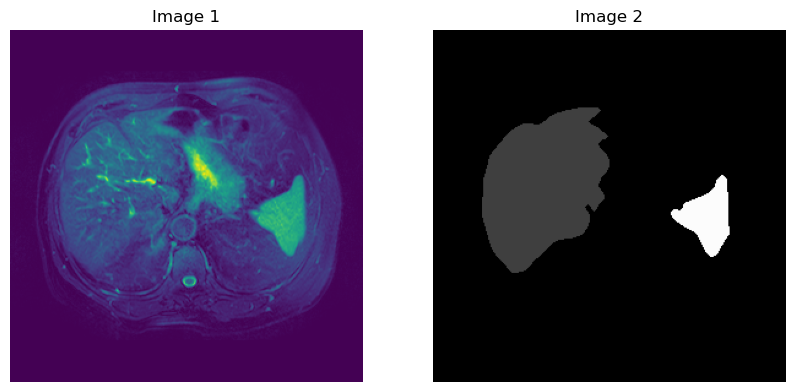

In [11]:
# specify your image path
mr_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/8/T2SPIR/DICOM_anon/IMG-0031-00021.dcm'
mr_im = dicom.dcmread(mr_path)

gt_mr_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/8/T2SPIR/Ground/IMG-0031-00021.png'
gt_mr = cv2.imread(gt_mr_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize for image sizes

axes[0].imshow(mr_im.pixel_array)
axes[0].set_title("Image 1")
axes[0].axis('off')  # Hide axes for cleaner presentation

axes[1].imshow(gt_mr)
axes[1].set_title("Image 2")
axes[1].axis('off')

plt.imshow(gt_mr,cmap='bone')

# plt.imshow(gt_mr)


constants

In [12]:
training_size : tuple = (256,256)

In [13]:
prod_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR'
dev_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/dev/MR'

dev_path_CT = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/dev/CT'

mr_path_train = prod_path +  '/train'
mr_path_test = prod_path +  '/test'

mr_path_train_dev = dev_path +  '/train'
mr_path_test_dev = dev_path +  '/test'

ct_path_train_dev = dev_path_CT +  '/train'
ct_path_test_dev = dev_path_CT +  '/test'

if os.path.exists(mr_path_train):
    shutil.rmtree(mr_path_train, ignore_errors=True)
if os.path.exists(mr_path_test):
    shutil.rmtree(mr_path_test, ignore_errors=True)

os.makedirs(mr_path_train,exist_ok=True)
os.makedirs(mr_path_test,exist_ok=True)

In [14]:
import random 
import os 
import re



# dirs = [ f.path.split('/')[-1] for f in os.scandir(base_path) if f.is_dir() ]
# random.shuffle(dirs)
# train_size = int(len(dirs) * 0.8)

# train_vols = set(dirs[:train_size])
# test_vols = set(dirs[train_size:])

# preconfigure train and test vols 

train_vols = set(['22', '8', '13', '15', '37', '10', '34', '20', '32', '21', '19', '36', '1', '33', '31', '5'])
test_vols = set(['2', '3', '39', '38'])

print(f"train vols: {train_vols}")
print(f"test vols: {test_vols}")

def is_train_vol(vol: str):
    return vol in train_vols

def get_data_save_path(im_path: str):
    pattern = r"/MR/(.*?)/"
    
    match = re.search(pattern,im_path)
    vol = match.group(1)
    
    im_name = im_path.split('/')[-1].split('.')[0]
    splitted_name = im_name.split('-')
    im_name_new = f'{splitted_name[0]}:VOL{vol}-{splitted_name[1]}_{int(splitted_name[2])}'
    im_name = f'/{im_name_new}'
    
    if is_train_vol(vol):
        return mr_path_train + im_name, vol
    else:
        return mr_path_test + im_name, vol

def get_data_save_path_sifa(sifa_path: str, is_ct : bool):
    
    file, vol = sifa_path.split('/')[-1], sifa_path.split('/')[-2]
    slice_idx = file.split('.')[0]
    
    im_name = f"/{vol}_{slice_idx}"
    
    if is_ct: 
        base_path = ct_path_train_dev
    else:
        base_path = mr_path_train_dev
    
    if is_train_vol(vol):
        return base_path + im_name, vol
    else:
        return base_path + im_name, vol

train vols: {'31', '15', '22', '10', '37', '32', '21', '19', '8', '36', '5', '34', '33', '20', '1', '13'}
test vols: {'39', '3', '38', '2'}


In [15]:
import os
import re
import random 
# /users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/8/T2SPIR/DICOM_anon/

base_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/'

im_path_list = []
gt_path_list = []

root_dirs = set()

pattern = r"/MR/(.*?)/"
for root,a,files in os.walk(base_path):
    if 'T2SPIR' not in root:
        continue
    if root.endswith('Ground'):
        continue 
    for file in files:
        full_path = os.path.join(root, file)
        full_path_gt = os.path.join(root.replace('DICOM_anon', 'Ground'), file.replace('.dcm','.png'))
        match = re.search(pattern,full_path_gt)
        vol = match.group(1)
        
        print(f"VOL IS {vol}")
        
        
        im_path_list.append(full_path)
        gt_path_list.append(full_path_gt)
        
        assert(full_path.split('/')[-1].split('.')[0] == full_path_gt.split('/')[-1].split('.')[0])
        
        root_dirs.add(root)

print(im_path_list)
print(gt_path_list)
print(root_dirs)

VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 1
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 10
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 13
VOL IS 15
VOL IS

In [23]:
# im_path_list = [mr_path]
# gt_path_list = [gt_mr_path]
from dataclasses import dataclass

@dataclass
class VolData:
    data_path: str
    image:  np.ndarray
    label: np.ndarray
    

vol_to_arr :dict[str,list[VolData]] = {}

for im_path,gt_path in zip(im_path_list,gt_path_list):
    mr_im = dicom.dcmread(im_path)
    gt_mr_vis = cv2.imread(gt_path)
    
    # reduce redundant dims (they are used for vis)
    gt_mr = gt_mr_vis[:,:,0]

    # 0 to 1552
    mr_im_data = mr_im.pixel_array
    
    # filter out empty images, "no foreground"
    if gt_mr.max() == 0:
        print("CONTINUE")
        continue
        
    filtered_gt = np.zeros_like(gt_mr)
    # swap to our tags
    for item in MRI_NUM_TO_TAG.items():
        filtered_gt = np.where(gt_mr == item[0], item[1], filtered_gt) 
    
    gt_mr = filtered_gt
    
    # crop out the body region with this bbox
    # **bbox** : tuple
    # Bounding box ``(min_row, min_col, max_row, max_col)``.
    # Pixels belonging to the bounding box are in the half-open interval
    # ``[min_row; max_row)`` and ``[min_col; max_col)``.
    
    
    
    bbox = get_china_bbox(mr_im_data)
    # bbox = get_bbox(mr_im_data)
    im_cropped  = mr_im_data[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    gt_cropped =  gt_mr[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    
    # bbox = get_china_bbox(mr_im_data)
    # im_cropped  = mr_im_data[bbox[0][0]:bbox[0][1], bbox[1][0]:bbox[1][1]]
    # gt_cropped =  gt_mr[bbox[0][0]:bbox[0][1], bbox[1][0]:bbox[1][1]]
    
    
    # NOTE - order 0 is `nearest neighbor` interpolation. We need it for the segmentation mask
    # NOTE - The image should be resized with some sort of interpolation,
    resized_gt = resize(gt_cropped, training_size, order=0, mode="edge", clip=True, anti_aliasing=False).astype(np.uint8)
    resized_im = resize(im_cropped.astype(float), training_size, order=3, mode="edge", clip=True, anti_aliasing=False).astype(np.int16)
    
    resized_im = np.clip(resized_im, 0, 1200)
    # minmax norm 
    # normed_im = (resized_im - resized_im.min()) / (resized_im.max() - resized_im.min())
    # normed_im = resized_im
    
    # print(im_cropped.shape)
    # print(im_cropped.dtype)
    # print(gt_cropped.dtype)
    # print(resized_im.max())
    
    
    im_name = im_path.split('/')[-1].split('.')[0]
    train_data = np.stack([resized_im, resized_gt])
    data_path, vol = get_data_save_path(im_path)
    
    # print(vol)
    
    if vol not in vol_to_arr:
        vol_to_arr[vol] = []
    resized_gt = resized_gt[np.newaxis, ...]
    vol_to_arr[vol].append(VolData(data_path, resized_im, resized_gt))
    
    
all_im_list : list = []
# derive dataset mean, std
for _,vol_data_list in vol_to_arr.items():
    all_im_list.extend([vol_data.image for vol_data in vol_data_list])
stacked_ims = np.stack(all_im_list)
print("DS STATS")
print(stacked_ims.mean())
print(stacked_ims.std())

derived_mean = stacked_ims.mean()
derived_std = stacked_ims.std()

# normalize
test_norm_list = []
for vol,vol_data_list in vol_to_arr.items():
    for item in vol_data_list:
        item.image =  norm_to_zero_mean_unit_var(item.image, derived_mean, derived_std)
        test_norm_list.append(item.image)
        
#test
stacked_test_norm = np.stack(test_norm_list)
print("Testing normalized values!!! Mean then STD:")
print(stacked_test_norm.mean())
print(stacked_test_norm.std())
print("Min and max values:")
print(f"MAX; {stacked_test_norm.max()}")
print(f"MIN; {stacked_test_norm.min()}")

    

for vol, vol_data_list in vol_to_arr.items():
    for idx,vol_data in enumerate(vol_data_list):
        mixed_image = None
        if idx == 0:
            next_slice = vol_data_list[idx+1]
            mixed_image = np.stack([vol_data.image,vol_data.image, next_slice.image])
        elif idx == len(vol_data_list) - 1:
            prev_slice = vol_data_list[idx - 1]
            mixed_image = np.stack([prev_slice.image, vol_data.image,vol_data.image])
        else:
            prev_slice = vol_data_list[idx - 1]
            next_slice = vol_data_list[idx+1]
            # print(f"getting slices {prev_slice}, {idx}, {next_slice}")
            mixed_image = np.stack([prev_slice.image, vol_data.image,next_slice.image])
        
            
        img = mixed_image.transpose(1,2,0)
        label = vol_data.label.transpose((1,2,0))[:,:,0]
        print(f"saving data to {vol_data.data_path}")
        np.savez(vol_data.data_path, image = img, label = label)
    
    



CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
CONTINUE
C

In [3]:
# test that the data was created successfully

test_im_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR/train/IMG:VOL1-0002_13.npz'
test_im_same_vol_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR/train/IMG:VOL1-0002_14.npz'
test_im_diff_vol_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR/train/IMG:VOL5-0014_9.npz'

def get_image_labels_from_npz(npz_path: str):
    test_im_npz = np.load(npz_path, allow_pickle=True)    
    return test_im_npz["image"], test_im_npz["label"]

test_im, test_gt = get_image_labels_from_npz(test_im_gt_path)
test_im_same_vol, test_gt_same_vol = get_image_labels_from_npz(test_im_same_vol_gt_path)
test_im_diff_vol, test_gt_diff_vol = get_image_labels_from_npz(test_im_diff_vol_gt_path)

print(test_im.shape)

assert test_gt.max() > 0
assert test_gt_same_vol.max() > 0
assert test_gt_diff_vol.max() > 0

assert np.all(test_im[:,:,0] == test_im[:,:,1])
assert np.any(test_im[:,:,0] != test_im[:,:,2])
assert np.all(test_im[:,:,2] == test_im_same_vol[:,:,1])

assert np.any(test_im_same_vol[:,:,2] != test_im_same_vol[:,:,1])
assert np.any(test_im_same_vol[:,:,0] != test_im_same_vol[:,:,2])
assert np.any(test_im_same_vol[:,:,0] != test_im_same_vol[:,:,1])

assert np.any(test_im[:,:,2] != test_im_diff_vol[:,:,1])
assert np.any(test_im[:,:,2] != test_im_diff_vol[:,:,2])
assert np.any(test_im[:,:,2] != test_im_diff_vol[:,:,0])

assert np.any(test_gt[:,:] != test_gt_diff_vol[:,:])
assert np.any(test_gt[:,:] != test_gt_diff_vol[:,:])
assert np.any(test_gt[:,:] != test_gt_diff_vol[:,:])

assert np.any(test_gt != test_gt_same_vol)
print(test_gt.sum())
print(test_gt_same_vol.sum())

one_image = test_im[:,:,1]
# bbox = get_bbox(one_image)
# assert(bbox[0] == 0)
# assert(bbox[1] == 0)
# assert(bbox[2] == one_image.shape[0])
# assert(bbox[3] == one_image.shape[1])




(256, 256, 3)
2780
6496


In [7]:
#visual test

test_im_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR/train/IMG:VOL1-0002_13.npz'

def add_mask(img,mask):  
    label2color = {0:np.array([0,0,0]),1:np.array([251,111,111]),2:np.array([240,130,40]),3:np.array([206,242,151]),4:np.array([238,172,255]),5:np.array([0,255,255])}
    
    pred_mask = np.zeros_like(img).astype(np.uint8)
    for l,color in label2color.items():
        pred_mask[mask==l, : ] = color
    img_pred = cv2.addWeighted(img,0.5,pred_mask,0.5,0,0)
    return img_pred
    
test_im, test_gt = get_image_labels_from_npz(test_im_gt_path)
im_vis = (test_im * 255).astype(np.uint8)
print(im_vis.shape)
test_im_same_vol, test_gt_same_vol = get_image_labels_from_npz(test_im_same_vol_gt_path)

masked_im = add_mask(im_vis,test_gt)

box = get_bbox(im_vis[:,:,1])

plt.imshow((test_gt ).astype(np.uint8))


FileNotFoundError: [Errno 2] No such file or directory: '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR/train/IMG:VOL1-0002_13.npz'

In [32]:
from models import get_model
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
import torch

def add_mask(img,mask):  
    label2color = {0:np.array([0,0,0]),1:np.array([251,111,111]),2:np.array([240,130,40]),3:np.array([206,242,151]),4:np.array([238,172,255]),5:np.array([0,255,255])}
    
    pred_mask = np.zeros_like(img).astype(mask.dtype)
    for l,color in label2color.items():
        pred_mask[mask==l, : ] = color
    img_pred = cv2.addWeighted(img,0.5,pred_mask,0.5,0,0)
    return img_pred
    

model_cfg = {'config_file': 'configs/train_source_seg_resume.yaml', 'gpu_id': 'cuda:0', 'experiment_name': 'UNet_Abdomen_CT_Seg', 'data_root': '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod', 'save_root': '/users/scratch/baryaacovi-2024-06-01/projects/MICCAI23-ProtoContra-SFDA', 'source_sites': ['MR'], 'eval_sites': ['CT'], 'resume_dir': '/users/scratch/baryaacovi-2024-06-01/projects/MICCAI23-ProtoContra-SFDA/res/UNet_Abdomen_MR_Seg/exp_13_time_2024-05-02 20:13:34_res', 'resume': '/users/scratch/baryaacovi-2024-06-01/projects/MICCAI23-ProtoContra-SFDA/res/UNet_Abdomen_MR_Seg/exp_13_time_2024-05-02 20:13:34/saved_models/best_model_epoch_100_dice_0.9317.pth', 'continue_train': True, 'total_epochs': 102, 'random_seed': 999, 'organ_list': ['Spleen', 'R.Kidney', 'L.Kidney', 'Liver'], 'img_size': (256, 256), 'batch_size': 16, 'num_workers': 8, 'arch': 'UNet', 'use_prototype': False, 'update_prototype': False, 'input_dim': 3, 'feat_dim': 32, 'output_dim': 64, 'num_classes': 5, 'lr': 0.001, 'ce_ignore_index': -1, 'dice_ignore_index': 0, 'save_epochs': 10, 'eval_epochs': 1, 'display_steps': 100, 'save_visuals': True, 'test': False, 'checkpoints_dir': '/users/scratch/baryaacovi-2024-06-01/projects/MICCAI23-ProtoContra-SFDA/UNet_Abdomen_CT_Seg', 'checkpoint_dir': '/users/scratch/baryaacovi-2024-06-01/projects/MICCAI23-ProtoContra-SFDA/UNet_Abdomen_CT_Seg/exp_24_time_2024-05-03 00:34:40'}

my_model = get_model(model_cfg)

state = torch.load(model_cfg['resume'])
my_model.load_state_dict(state['model'])

my_model.eval()

path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/test/img0022_21.npz'
# path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR/test/IMG:VOL2-0007_9.npz'
im,lb = get_image_labels_from_npz(path)

data_transforms = albumentations.Compose([
    albumentations.Resize(256,256),
    ToTensorV2()
    ])


transim = data_transforms(image=im)
im_im = transim['image'].unsqueeze(0)

print(im_im.dtype)

_,predict = my_model(im_im.float())

print(predict.shape)
seg = F.softmax(predict,dim=1)

seg_mask = seg.argmax(1)


torch.float64
torch.Size([1, 5, 256, 256])


torch.int64
int64
uint8


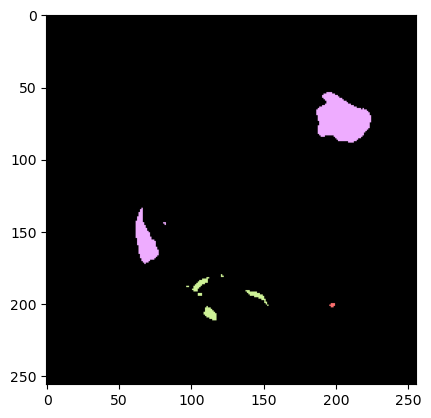

In [ ]:
import torch
import torch.types 

print(seg_mask[0].dtype)
print(im.astype(np.int64).dtype)

seg_mask_n = seg_mask[0].numpy().astype(np.int16)
# seg_mask_n = lb
im_n = im



# ret = add_mask(im_n,seg_mask_n)

# plt.imshow((im_n * 255).astype(np.uint8))

# plt.imshow(seg_mask_n.astype(np.uint8))

label2color = {0:np.array([0,0,0]),1:np.array([251,111,111]),2:np.array([240,130,40]),3:np.array([206,242,151]),4:np.array([238,172,255]),5:np.array([0,255,255])}

pred_mask = np.zeros_like(seg_mask_n).astype(np.uint8)
pred_mask_n = np.stack([pred_mask,pred_mask,pred_mask]).transpose(1,2,0)
for l,color in label2color.items():
    pred_mask_n[seg_mask_n==l, : ] = color
    
    
print(pred_mask_n.dtype)
plt.imshow(pred_mask_n)

1.952653
-0.9880333


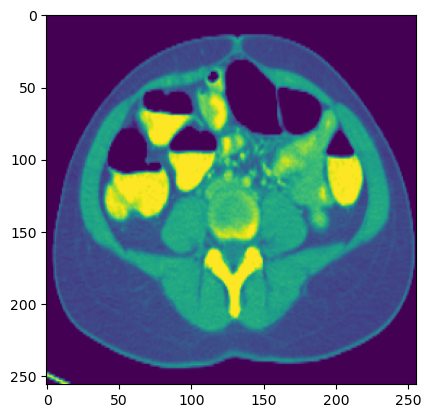

In [137]:
sifa_path = '/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/CT_npy/10/015.npz'
# sifa_path = '/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/10/007.npz'
sifa_path = '/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/CT_npy/21/001.npz'

a = np.load(sifa_path)
im = a['arr_0']
lb = a['arr_1']

print(im.max())
print(im.min())


plt.imshow(im)

(256, 256, 3)
3.2775302958114225
-0.7124789066081676
255.0
0.0
(256, 256, 3)
max label: 29175 , max tag: 1


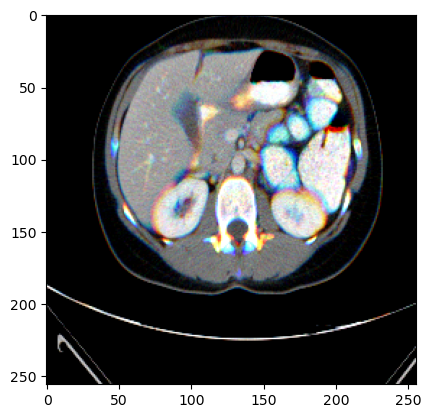

In [42]:
# def get_bbox(array: np.ndarray):
#     array_for_bbox =  (array > 0).astype(np.uint8)
    
#     bbox = regionprops(array_for_bbox)[0].bbox
    
#     return bbox

path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR/train/IMG:VOL10-0043_14.npz'
path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/MR/train/IMG:VOL5-0014_16.npz'

path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/train/img0021_27.npz'
im,lb = get_image_labels_from_npz(path)

print(im.shape)

print(im.max())
print(im.min())

im = (im - im.min()) / (im.max() - im.min()) * 255

print(im.max())
print(im.min())

print(im.shape)
# im = np.flip(im, axis=0)

# if '/CT' in path:
#     im = np.flip(im, axis=1)
#     im = im.transpose(1,0,2)

array_for_bbox =  (im > 0).astype(np.uint8)[:,:,1]

bbox = regionprops(array_for_bbox)

labeled = sklabel(array_for_bbox)

# im = im [:50,:,:]

max_labeled = 0
max_tag = 0
for i in range(1, labeled.max()):
    cur_sum = (labeled == i).sum()
    if cur_sum > max_labeled:
        max_labeled = cur_sum
        max_tag = i
        print(f"max label: {max_labeled} , max tag: {max_tag}")

cur_label = (labeled == max_tag).astype(np.uint8)

maksed_im = add_mask(im.astype(np.int16), cur_label.astype(np.int16))

plt.imshow((maksed_im).astype(np.int16))

In [27]:
import os 

sifa_path = '/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy'

total_max = -100
total_min = 100

for root,a,files in os.walk(sifa_path):
    print(root)
    for file in files:
        path = os.path.join(root, file)
        a = np.load(path)
        im = a['arr_0']
        lb = a['arr_1']
        max = im.max()
        min = im.min()
        
        save_path = get_data_save_path_sifa(path, is_ct = False)[0]
        np.savez(save_path, image=im, label=lb)
        
        if max > total_max:
            total_max = max
        if min < total_min:
            total_min = min
        

print(f"{total_max}")
print(f"{total_min}")




/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/8
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/5
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/39
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/38
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/37
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/36
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/34
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/33
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/32
/users/scratch/baryaacovi-2024-06-01/projects/downloads/abdo/abdominalDATA/MR_T2_npy/31
/users/scratch/baryaacovi-2024-06-01/